## A pipeline for processing and analyzing multiplexed images

#### Developed for related project: A spatial single-cell type map of adult human spermatogenesis (Cecilia Bergström's group)

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import io
import sklearn
import time

# stardist
from stardist.models import StarDist2D, Config2D
from stardist.plot import render_label
from csbdeep.utils import normalize

from skimage import io, filters, measure, segmentation, color, util, exposure, morphology
from skimage.filters import threshold_otsu

from tiler import Tiler, Merger 

import warnings
warnings.filterwarnings('ignore')

%run ../src/functions.py

2024-09-10 17:46:00.789444: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
auto.py (21): IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Define input path, image of interest and other parameters

In [2]:
# set distance to be used to grow the cell after segmentation
dist = 3

# set the segmentation method
seg_method = 'stardist' # choose between 'cellpose' of 'stardist'

# set startdist parameters
nms_thresh = 0.8
prob_thresh = 0.7
 
# pre-process OPAL channels? True or False
preprocessOPAL = False 

# apply size filter to segmented objetcts
filterByArea = True
min_size = np.array([0,100,100,100,100,100,100,0]) # define value per channel
max_size = np.array([100000,100000,100000,100000,100000,100000,100000,100000]) # define value per channel

# define levels of Ostu threshold
#multi_otsu = False
multi_otsu_levels = np.array([0,2,2,2,2,2,2,0])

# set order of the channels
cols = ['DAPI','OPAL480','OPAL520','OPAL570','OPAL620','OPAL690','OPAL780','Autofluorescence']

# save output image files
save_img = False

# split image before segmentation
split = False

## Running the pipeline for reference image

### Load image of interest and define channel to be segmented

Nuclei and AF channel: loaded  (3996, 3996)
Pre-processing cell image: finished


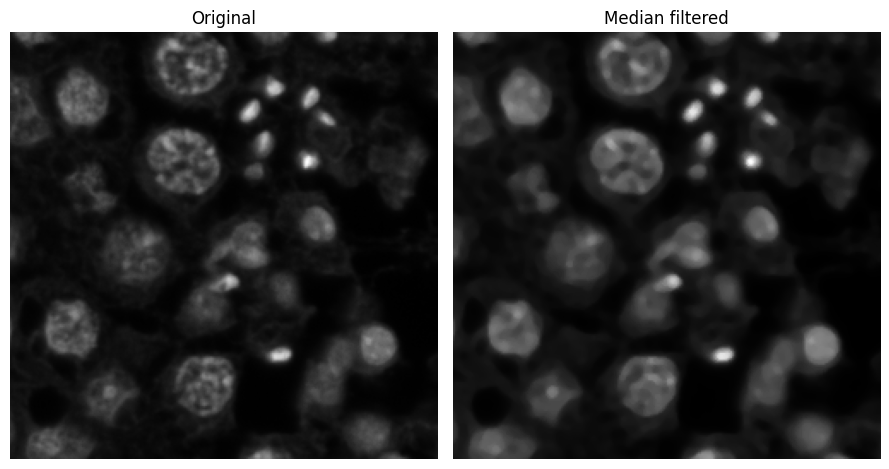

In [3]:
# Define paths
path = '../data/20456931/' # update input path!
ref_image = '20456931_Core[1,2,A]_[13058,43408]_component_data.tif'
ilastik_mask = '20456931_Core1,2,A_13058,43408_component_data_520_Simple Segmentation.tiff'

outpath = path + '/output_nms-' + str(nms_thresh) + '_prob-' + str(prob_thresh)
if not os.path.exists(outpath):
    os.makedirs(outpath)

# Read reference image

ref_img = io.imread(os.path.join(path, ref_image))

# Select channel to be segmented
original = ref_img[0,:,:] + ref_img[7,:,:]
print("Nuclei and AF channel: loaded ", original.shape)

# Apply pre-processing to the AF channel
filtered = preprocess(original)
print("Pre-processing cell image: finished")

# Show pre-processing
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(9, 5),
    sharex=True,
    sharey=True,
)

axes[0].imshow(exposure.rescale_intensity(original[1000:1250, 1000:1250]), cmap="gray")
axes[0].set_title("Original")

axes[1].imshow(exposure.rescale_intensity(filtered[1000:1250, 1000:1250]), cmap="gray")
axes[1].set_title("Median filtered")

for a in axes:
    a.axis("off")
fig.tight_layout()
plt.show()

### Run cell segmentation and save both label and binary masks

segmenting...
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


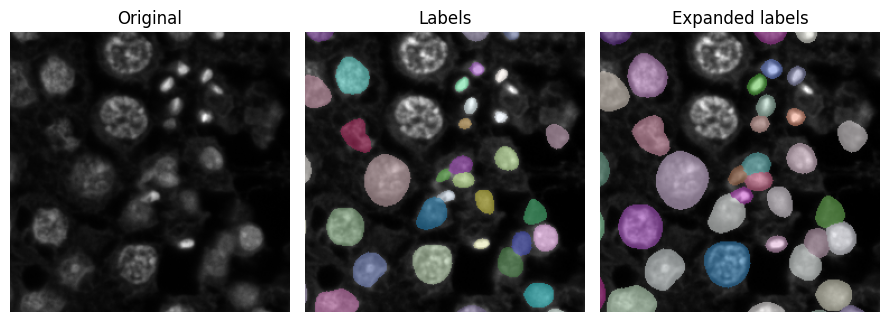

In [4]:
# if split option is set True, then split in tiles
if split:
    image16 = filtered.astype('uint16')
    full_image = np.reshape(image16, [1, filtered.shape[0], filtered.shape[1]])

    blockSize = 2000
    # Setup tiling parameters
    tiler = Tiler(data_shape=full_image.shape,tile_shape=(1, blockSize, blockSize),overlap=0,channel_dimension=0)
    merger = Merger(tiler)

    countLabels = 0
    
    # Process the image tile-by-tile
    for tile_id, tile in tiler(full_image):
        print(f"processing tile {tile_id}...")
        # run inference
        
        tile_new = tile[0,:,:]
        
        labels = segment_with_stardist(normalize(tile_new),[nms_thresh, prob_thresh])    
        maxLabelTile = np.amax(labels) # get max label of the current mask
        labels = np.where(labels > 0, labels+countLabels, labels) # sum countLabels to the current mask
        countLabels = countLabels + maxLabelTile # sum current max label to countLabels

        tile_res = np.reshape(labels, [1, labels.shape[0], labels.shape[1]])
        merger.add(tile_id, tile_res)
        
    # Merge the image
    merged_image = merger.merge(unpad=True)
    io.imsave(outpath + '/_testDAPI_segmented_merged.tif',merged_image.astype('uint16'))

    labels = stitchSegmentedTiles(merged_image, blockSize)
    labels = labels[:,:,0]
    io.imsave(outpath + '/_testDAPI_segmented_merged_labeled.tif',labels.astype('uint16'))
else:
    print('segmenting...')
    labels = segment_with_stardist(normalize(filtered),[nms_thresh, prob_thresh])
    
# Get binary mask
binary_mask = labels.copy()
binary_mask[binary_mask > 0] = 1

io.imsave(outpath + '/_cells_labels.tif',labels)
io.imsave(outpath + '/_cells_binary.tif',util.img_as_ubyte(binary_mask*255))

### Expand labels to incorporate cells' neighborhoods
expanded_labels = segmentation.expand_labels(labels, distance=dist)
io.imsave(outpath + '/_cells_labels_expanded.tif',expanded_labels)

# Show the segmentations.
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(9, 5),
    sharex=True,
    sharey=True,
)

axes[0].imshow(exposure.rescale_intensity(original[1000:1250, 1000:1250]), cmap="gray")
axes[0].set_title("Original")

axes[1].imshow(render_label(labels, img=original)[1000:1250, 1000:1250])
axes[1].set_title("Labels")

axes[2].imshow(render_label(expanded_labels, img=original)[1000:1250, 1000:1250])
axes[2].set_title("Expanded labels")

for a in axes:
    a.axis("off")
fig.tight_layout()
plt.show()

## Retrieve quantitative measures
### 1) Get mean fluorescence intensity for each nuclei and for each channel. Save results on a dataframe


In [5]:
properties = ['label', 'intensity_mean']

mean_intens = get_avg_intensity(ref_img, expanded_labels, cols, properties)

# add file id
ref_series = pd.Series(ref_image)
ref_series = ref_series.repeat(mean_intens.shape[0])
mean_intens['file'] = ref_series.values
mean_intens.reset_index(['label'],inplace=True)
mean_intens.set_index(['file','label'],inplace=True)
# save as csv
mean_intens.to_csv(os.path.join(outpath, 'mean_intensity.csv'), sep=';')

# exclude DAPI, AF and OPAL520 from dataframe
mean_intens_OPAL = mean_intens.drop(columns=['DAPI', 'Autofluorescence', 'OPAL520'], axis=1)

# rearrange cols
cols_sorted = ['OPAL480', 'OPAL620', 'OPAL690', 'OPAL780', 'OPAL570']
mean_intens_OPAL = mean_intens_OPAL[cols_sorted]
mean_intens_OPAL

OPAL480  \
file                                               label              
20456931_Core[1,2,A]_[13058,43408]_component_da... 1       1.068015   
                                                   2      70.599594   
                                                   3       1.132329   
                                                   4       5.196221   
                                                   5       1.961846   
...                                                             ...   
                                                   4300    0.533827   
                                                   4301    1.348614   
                                                   4302    3.182064   
                                                   4303    2.069062   
                                                   4304    0.597824   

                                                            OPAL620   OPAL690  \
file                                               label                        
20456931_Core[1,2,A]_[13058,43408]_component_da... 1       1.124044  1.032820   
                                                   2       1.300546  0.441883   
                                                   3       2.122557  1.801705   
                                                   4      42.942066  2.368237   
                                                   5       1.780363  0.770447   
...                                                             ...       ...   
                                                   4300    3.016607  0.085312   
                                                   4301    4.073256  0.204206   
                                                   4302    2.187496  0.633910   
                                                   4303    0.525709  0.442185   
                                                   4304    2.043633  3.516830   

                                                           OPAL780   OPAL570  
file                                               label                      
20456931_Core[1,2,A]_[13058,43408]_component_da... 1      0.097457  0.022274  
                                                   2      0.036893  0.000641  
                                                   3      0.127502  0.187741  
                                                   4      0.219000  0.006045  
                                                   5      0.133974  0.024485  
...                                                            ...       ...  
                                                   4300   0.054917  0.012769  
                                                   4301   0.070897  0.002780  
                                                   4302   0.186348  0.588063  
                                                   4303   0.024981  0.019627  
                                                   4304   0.125966  2.415965  

[4304 rows x 5 columns]

### 2) Get mean fluorescence intensity for each nuclei and for each channel, given the thresholded masks, and save results on a dataframe

In [6]:
# get enlarged-labels image as a binary mask
expanded_binary_mask = expanded_labels.copy()
expanded_binary_mask[expanded_binary_mask > 0] = 1

# OPAL quantification
ilastik_mask = path + ilastik_mask
print(ilastik_mask)
mean_intens_thres, thresholded, intens_masks = opal_quantification(ref_img, expanded_labels, expanded_binary_mask, ilastik_mask, cols, filterByArea, min_size, max_size, preprocessOPAL, multi_otsu_levels)

# filter ['DAPI', 'Autofluorescence'] out
mean_intens_thres = filter_columns(['DAPI', 'Autofluorescence'], mean_intens_thres)

# add file id
mean_intens_thres['file'] = ref_series.values
mean_intens_thres.reset_index(['label'],inplace=True)
mean_intens_thres.set_index(['file','label'],inplace=True)
mean_intens_thres.to_csv(os.path.join(outpath, 'mean_intensity_threshold.csv'), sep=';')

mean_intens_thres

../data/20456931/20456931_Core1,2,A_13058,43408_component_data_520_Simple Segmentation.tiff
channel: DAPI
channel: OPAL480
channel: OPAL520
channel: OPAL570
channel: OPAL620
channel: OPAL690
channel: OPAL780
channel: Autofluorescence


OPAL480    OPAL520  \
file                                               label                       
20456931_Core[1,2,A]_[13058,43408]_component_da... 1       0.0000  23.407122   
                                                   2      80.5771   0.000000   
                                                   3       0.0000  23.239545   
                                                   4       0.0000  29.145781   
                                                   5       0.0000  25.085258   
...                                                           ...        ...   
                                                   4300    0.0000   0.000000   
                                                   4301    0.0000   0.000000   
                                                   4302    0.0000   0.000000   
                                                   4303    0.0000   0.000000   
                                                   4304    0.0000  19.458442   

                                                           OPAL570    OPAL620  \
file                                               label                        
20456931_Core[1,2,A]_[13058,43408]_component_da... 1      0.000000   0.000000   
                                                   2      0.000000   0.000000   
                                                   3      0.000000   0.000000   
                                                   4      0.000000  45.704957   
                                                   5      0.000000   0.000000   
...                                                            ...        ...   
                                                   4300   0.000000   0.000000   
                                                   4301   0.000000   0.000000   
                                                   4302   0.000000   0.000000   
                                                   4303   0.000000   0.000000   
                                                   4304   5.953085   0.000000   

                                                          OPAL690   OPAL780  
file                                               label                     
20456931_Core[1,2,A]_[13058,43408]_component_da... 1          0.0  0.286640  
                                                   2          0.0  0.232376  
                                                   3          0.0  0.307035  
                                                   4          0.0  0.317763  
                                                   5          0.0  0.320948  
...                                                           ...       ...  
                                                   4300       0.0  0.000000  
                                                   4301       0.0  0.000000  
                                                   4302       0.0  0.000000  
                                                   4303       0.0  0.328865  
                                                   4304       0.0  0.000000  

[4304 rows x 6 columns]

In [7]:
# save masks
cols_filtered = ['OPAL480','OPAL520','OPAL570','OPAL620','OPAL690','OPAL780']
save_results_opal_quantification(cols_filtered, outpath + '/' + ref_image , thresholded, intens_masks)

# filter ['OPAL520'] out
mean_intens_thres_OPAL = filter_columns(['OPAL520'], mean_intens_thres)

# rearrange cols order
cols_sorted = ['OPAL480', 'OPAL620', 'OPAL690', 'OPAL780', 'OPAL570']
mean_intens_thres_OPAL = mean_intens_thres_OPAL[cols_sorted]
mean_intens_thres_OPAL

OPAL480    OPAL620  \
file                                               label                       
20456931_Core[1,2,A]_[13058,43408]_component_da... 1       0.0000   0.000000   
                                                   2      80.5771   0.000000   
                                                   3       0.0000   0.000000   
                                                   4       0.0000  45.704957   
                                                   5       0.0000   0.000000   
...                                                           ...        ...   
                                                   4300    0.0000   0.000000   
                                                   4301    0.0000   0.000000   
                                                   4302    0.0000   0.000000   
                                                   4303    0.0000   0.000000   
                                                   4304    0.0000   0.000000   

                                                          OPAL690   OPAL780  \
file                                               label                      
20456931_Core[1,2,A]_[13058,43408]_component_da... 1          0.0  0.286640   
                                                   2          0.0  0.232376   
                                                   3          0.0  0.307035   
                                                   4          0.0  0.317763   
                                                   5          0.0  0.320948   
...                                                           ...       ...   
                                                   4300       0.0  0.000000   
                                                   4301       0.0  0.000000   
                                                   4302       0.0  0.000000   
                                                   4303       0.0  0.328865   
                                                   4304       0.0  0.000000   

                                                           OPAL570  
file                                               label            
20456931_Core[1,2,A]_[13058,43408]_component_da... 1      0.000000  
                                                   2      0.000000  
                                                   3      0.000000  
                                                   4      0.000000  
                                                   5      0.000000  
...                                                            ...  
                                                   4300   0.000000  
                                                   4301   0.000000  
                                                   4302   0.000000  
                                                   4303   0.000000  
                                                   4304   5.953085  

[4304 rows x 5 columns]

In [8]:
# remove rows with all cols zero value
mean_intens_thres_OPAL_nonzero = mean_intens_thres_OPAL.loc[~(mean_intens_thres_OPAL==0).all(axis=1)]
mean_intens_thres_OPAL_nonzero

# counting of cols with values > 0 per row
OPAL_counts = mean_intens_thres_OPAL_nonzero.copy()
OPAL_counts['total_positive'] = mean_intens_thres_OPAL_nonzero[mean_intens_thres_OPAL_nonzero > 0].count(axis='columns')
OPAL_counts

OPAL480    OPAL620  \
file                                               label                       
20456931_Core[1,2,A]_[13058,43408]_component_da... 1       0.0000   0.000000   
                                                   2      80.5771   0.000000   
                                                   3       0.0000   0.000000   
                                                   4       0.0000  45.704957   
                                                   5       0.0000   0.000000   
...                                                           ...        ...   
                                                   4295    0.0000   0.000000   
                                                   4297    0.0000   0.000000   
                                                   4299    0.0000  13.195857   
                                                   4303    0.0000   0.000000   
                                                   4304    0.0000   0.000000   

                                                          OPAL690   OPAL780  \
file                                               label                      
20456931_Core[1,2,A]_[13058,43408]_component_da... 1          0.0  0.286640   
                                                   2          0.0  0.232376   
                                                   3          0.0  0.307035   
                                                   4          0.0  0.317763   
                                                   5          0.0  0.320948   
...                                                           ...       ...   
                                                   4295       0.0  0.370619   
                                                   4297       0.0  0.471674   
                                                   4299       0.0  0.355611   
                                                   4303       0.0  0.328865   
                                                   4304       0.0  0.000000   

                                                           OPAL570  \
file                                               label             
20456931_Core[1,2,A]_[13058,43408]_component_da... 1      0.000000   
                                                   2      0.000000   
                                                   3      0.000000   
                                                   4      0.000000   
                                                   5      0.000000   
...                                                            ...   
                                                   4295   0.000000   
                                                   4297   0.000000   
                                                   4299   0.000000   
                                                   4303   0.000000   
                                                   4304   5.953085   

                                                          total_positive  
file                                               label                  
20456931_Core[1,2,A]_[13058,43408]_component_da... 1                   1  
                                                   2                   2  
                                                   3                   1  
                                                   4                   2  
                                                   5                   1  
...                                                                  ...  
                                                   4295                1  
                                                   4297                1  
                                                   4299                2  
                                                   4303                1  
                                                   4304                1  

[2930 rows x 6 columns]

#### Distribution of postive signals per col

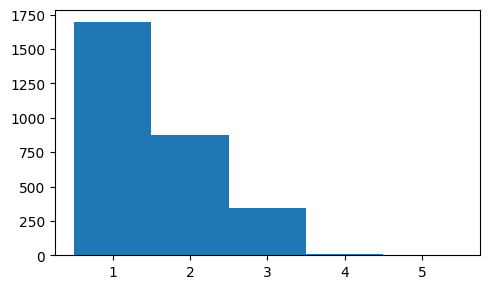

In [9]:
# plot histogram of total_positive
fig, ax = plt.subplots(figsize=(5, 3))
n, bins, patches = ax.hist(OPAL_counts['total_positive'], bins=[1,2,3,4,5,6], align='left')
fig.tight_layout()
plt.show()

In [10]:
# transform the data to count unique patterns
mean_intens_unit = mean_intens_thres_OPAL.copy()
mean_intens_unit = mean_intens_unit.loc[~(mean_intens_unit==0).all(axis=1)]
mean_intens_unit[mean_intens_unit > 0] = 1
mean_intens_unit

OPAL480  OPAL620  \
file                                               label                     
20456931_Core[1,2,A]_[13058,43408]_component_da... 1          0.0      0.0   
                                                   2          1.0      0.0   
                                                   3          0.0      0.0   
                                                   4          0.0      1.0   
                                                   5          0.0      0.0   
...                                                           ...      ...   
                                                   4295       0.0      0.0   
                                                   4297       0.0      0.0   
                                                   4299       0.0      1.0   
                                                   4303       0.0      0.0   
                                                   4304       0.0      0.0   

                                                          OPAL690  OPAL780  \
file                                               label                     
20456931_Core[1,2,A]_[13058,43408]_component_da... 1          0.0      1.0   
                                                   2          0.0      1.0   
                                                   3          0.0      1.0   
                                                   4          0.0      1.0   
                                                   5          0.0      1.0   
...                                                           ...      ...   
                                                   4295       0.0      1.0   
                                                   4297       0.0      1.0   
                                                   4299       0.0      1.0   
                                                   4303       0.0      1.0   
                                                   4304       0.0      0.0   

                                                          OPAL570  
file                                               label           
20456931_Core[1,2,A]_[13058,43408]_component_da... 1          0.0  
                                                   2          0.0  
                                                   3          0.0  
                                                   4          0.0  
                                                   5          0.0  
...                                                           ...  
                                                   4295       0.0  
                                                   4297       0.0  
                                                   4299       0.0  
                                                   4303       0.0  
                                                   4304       1.0  

[2930 rows x 5 columns]

In [11]:
# show distribution of positive signals
mean_intens_unit.groupby(mean_intens_unit.columns.tolist(),as_index=False).size()

,OPAL480,OPAL620,OPAL690,OPAL780,OPAL570,size
0,0.0,0.0,0.0,0.0,1.0,42
1,0.0,0.0,0.0,1.0,0.0,1320
2,0.0,0.0,0.0,1.0,1.0,67
3,0.0,0.0,1.0,0.0,0.0,77
4,0.0,0.0,1.0,1.0,0.0,225
5,0.0,0.0,1.0,1.0,1.0,5
6,0.0,1.0,0.0,0.0,0.0,162
7,0.0,1.0,0.0,0.0,1.0,1
8,0.0,1.0,0.0,1.0,0.0,383
9,0.0,1.0,1.0,0.0,0.0,86
